In [ ]:
#1: to connect to drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#2: to have shorter path
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
#!ls /mydrive/colab/NordTank/darknet/data/ds_files/
%cd /mydrive/co1/newData

/content/gdrive/My Drive/co1/newData


In [ ]:
%pwd

'/content/gdrive/My Drive/co1/newData'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

In [ ]:
from sklearn import preprocessing

In [ ]:
df = pd.read_excel('2941_2_lable.xlsx')
df=df.drop(["car_id", "timestamp", "alt", "satellites", "overspeedingtotaldistance", "bearing", "signalstrength", "totalidlingtime", "lat", "lng", "alarm", "hdop", "totalodometer", "obd_totalodometer", "switchlockendtime", "batterypercentage", "externalvoltage", "ERROR"],axis=1)
#print(df["ERROR"].value_counts()[1])
df=df.dropna()
#df4 = df["ERROR"]
#df=df.drop(["ERROR"],axis=1)
df.head()

#print(df)

min_max_Scalar = preprocessing.MinMaxScaler()

col = df.columns
result = min_max_Scalar.fit_transform(df)
min_max_Scalar_df = pd.DataFrame(result, columns=col)
df = min_max_Scalar_df
df.describe()


In [ ]:
import pandas as pd

df.to_csv('sahar2', sep='\t')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   car_id                              2016 non-null   float64
 1   obd_upstreamo2sensorvoltage         2016 non-null   float64
 2   alt                                 2016 non-null   float64
 3   satellites                          2016 non-null   float64
 4   speed                               2016 non-null   float64
 5   obd_intakeairtemperature            2016 non-null   float64
 6   obd_intakemanifoldabsolutepressure  2016 non-null   float64
 7   obd_calculatedengineload            2016 non-null   float64
 8   movement                            2016 non-null   float64
 9   overspeedingtotaldistance           2016 non-null   float64
 10  ignition                            2016 non-null   float64
 11  obd_coilchargingtime                2016 no

In [ ]:
df2=df.drop(["ERROR"],axis=1)

KeyError: ignored

In [ ]:
import tensorflow as tf
import random as rn

# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 16316
VALIDATE_SIZE = 0.2
# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)


In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.33, random_state=1)

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(df_train, test_size=VALIDATE_SIZE, random_state=RANDOM_SEED)
# summarize
print('Train', X_train.shape)
print('Test', df_test.shape)
print('validate', X_validate.shape)


Train (1080, 31)
Test (666, 31)
validate (270, 31)


In [ ]:
# Load the extension and start TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs

In [ ]:
# data dimensions // hyperparameters
input_dim = X_train.shape[1]
BATCH_SIZE = 10
EPOCHS = 50

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
    #tf.keras.layers.Dense(10, activation='elu'),
    #tf.keras.layers.Dense(7, activation='elu'),
    #tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    #tf.keras.layers.Dense(48, activation='elu'),

    #tf.keras.layers.Dense(8, activation='elu'),

    # reconstruction / decode
    #tf.keras.layers.Dense(7, activation='elu'),
    #tf.keras.layers.Dense(10, activation='elu'),
    #tf.keras.layers.Dense(4, activation='elu'),
    #tf.keras.layers.Dense(7, activation='elu'),
    #tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')

])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam",
                    loss="mae",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 31)                992       
                                                                 
 dense_1 (Dense)             (None, 2)                 64        
                                                                 
 dense_2 (Dense)             (None, 31)                93        
                                                                 
Total params: 1149 (4.49 KB)
Trainable params: 1149 (4.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
 from datetime import datetime

# # current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# # new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# # define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

In [ ]:
history = autoencoder.fit(
    X_train, X_train,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate, X_validate)
);

Epoch 1/50
108/108 [==============================] - ETA: 0s - loss: 0.0576 - acc: 0.7574

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 3s 18ms/step - loss: 0.0576 - acc: 0.7574 - val_loss: 0.0422 - val_acc: 0.9630
Epoch 2/50
108/108 [==============================] - 1s 14ms/step - loss: 0.0388 - acc: 0.9815 - val_loss: 0.0345 - val_acc: 0.9704
Epoch 3/50
108/108 [==============================] - 1s 9ms/step - loss: 0.0311 - acc: 0.9815 - val_loss: 0.0255 - val_acc: 0.9704
Epoch 4/50
108/108 [==============================] - 1s 7ms/step - loss: 0.0184 - acc: 0.9815 - val_loss: 0.0122 - val_acc: 0.9704
Epoch 5/50
108/108 [==============================] - 1s 12ms/step - loss: 0.0128 - acc: 0.9815 - val_loss: 0.0121 - val_acc: 0.9704
Epoch 6/50
108/108 [==============================] - 2s 17ms/step - loss: 0.0128 - acc: 0.9815 - val_loss: 0.0122 - val_acc: 0.9704
Epoch 7/50
108/108 [==============================] - 2s 16ms/step - loss: 0.0127 - acc: 0.9815 - val_loss: 0.0122 - val_acc: 0.9704
Epoch 8/50
108/108 [==============================] - 2s 18ms/step - loss: 0.0127 

In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

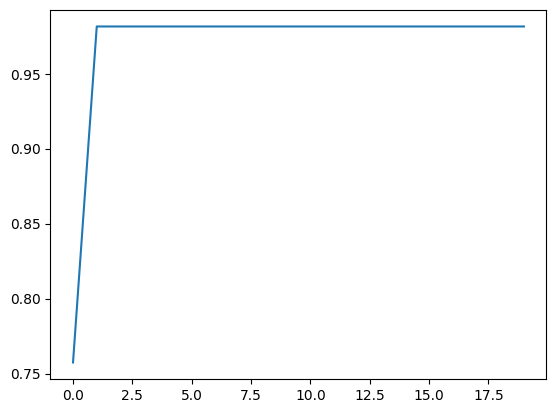

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])

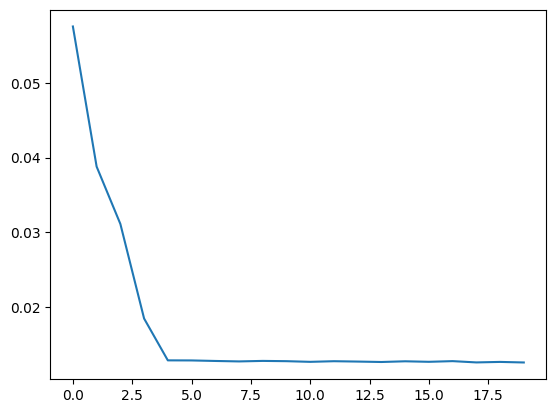

In [ ]:
plt.plot(history.history['loss'])

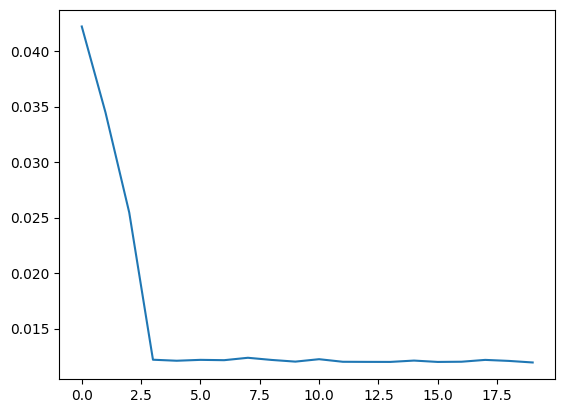

In [ ]:
plt.plot(history.history['val_loss'])

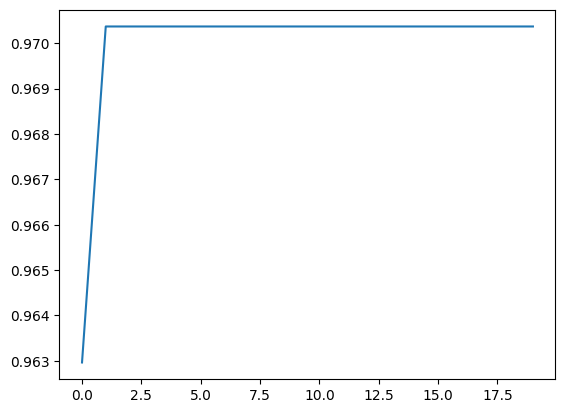

In [ ]:
plt.plot(history.history['val_acc'])

In [ ]:
encoder = Model(autoencoder.input, autoencoder.get_layer('dense_1').output)
data_enc = encoder.predict(X_train)  # bottleneck representation
data_dec = autoencoder.predict(X_train)   # reconstruction

34/34 [==============================] - 0s 1ms/step


In [ ]:
data_enc

array([[0.61472255, 0.18814628],
       [0.61156636, 0.18745537],
       [0.6118985 , 0.18754748],
       ...,
       [0.61282855, 0.18969521],
       [0.61211574, 0.18760581],
       [0.61279434, 0.19054683]], dtype=float32)

In [ ]:
data_dec1=pd.DataFrame(data_dec)
data_enc2=pd.DataFrame(data_enc)

data_dec1


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.000146,-0.000720,-1.550913e-04,0.000191,0.000069,0.000104,-0.000394,-0.000107,-0.000517,0.000108,...,0.000446,0.000185,-0.000269,-0.000274,0.000264,0.226219,0.000116,1.001969,0.000046,0.000737
1,-0.000259,-0.000623,-8.440018e-05,0.000468,0.000121,-0.000304,0.000023,-0.000033,0.000013,0.000511,...,-0.000016,0.000544,0.000006,0.000240,-0.000091,0.225708,0.000020,0.998999,0.000306,0.000475
2,-0.000214,-0.000639,-9.077787e-05,0.000446,0.000120,-0.000260,-0.000018,-0.000043,-0.000045,0.000471,...,0.000029,0.000508,-0.000024,0.000182,-0.000052,0.225755,0.000033,0.999318,0.000285,0.000501
3,-0.000037,-0.000693,-1.189113e-04,0.000342,0.000105,-0.000083,-0.000192,-0.000078,-0.000275,0.000302,...,0.000219,0.000359,-0.000143,-0.000046,0.000103,0.225962,0.000080,1.000604,0.000185,0.000611
4,-0.000170,-0.000082,-2.403259e-04,-0.000465,-0.000284,-0.000139,-0.000516,0.000114,-0.000169,0.000031,...,0.000683,0.000079,-0.000106,0.000297,-0.000006,0.226663,-0.000208,1.000321,-0.000473,0.000778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,0.000024,-0.000706,-1.299977e-04,0.000298,0.000096,-0.000021,-0.000256,-0.000089,-0.000356,0.000240,...,0.000291,0.000304,-0.000185,-0.000124,0.000157,0.226042,0.000094,1.001056,0.000144,0.000651
1076,-0.000233,-0.000023,-2.403259e-04,-0.000490,-0.000306,-0.000197,-0.000486,0.000139,-0.000092,0.000063,...,0.000658,0.000105,-0.000067,0.000390,-0.000060,0.226649,-0.000243,0.999912,-0.000488,0.000757
1077,0.000095,-0.001289,-7.748604e-07,0.001128,0.000484,-0.000026,0.000123,-0.000267,-0.000382,0.000565,...,-0.000231,0.000631,-0.000182,-0.000384,0.000211,0.225281,0.000362,1.000898,0.000826,0.000449
1078,-0.000185,-0.000650,-9.500980e-05,0.000431,0.000118,-0.000232,-0.000045,-0.000049,-0.000082,0.000444,...,0.000058,0.000485,-0.000043,0.000144,-0.000027,0.225787,0.000041,0.999527,0.000271,0.000519


In [ ]:
data_enc2[0]

0       0.614723
1       0.611566
2       0.611898
3       0.613251
4       0.613702
          ...   
1075    0.613733
1076    0.613324
1077    0.612829
1078    0.612116
1079    0.612794
Name: 0, Length: 1080, dtype: float32

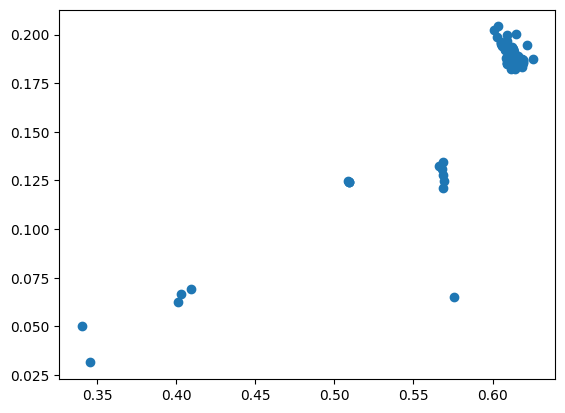

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(data_enc2[0], data_enc2[1])

In [ ]:
data_enc[:,0]

array([0.61472255, 0.61156636, 0.6118985 , ..., 0.61282855, 0.61211574,
       0.61279434], dtype=float32)

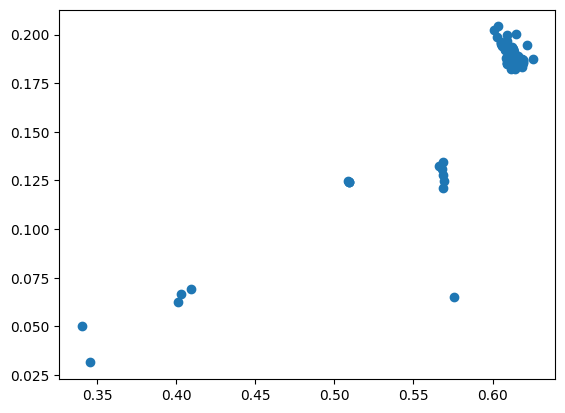

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.scatter(data_enc[:,0], data_enc[:,1])
plt.show()
plt.tight_layout()

In [ ]:
df_test2 = df_test.reset_index(drop=True)
reconstructions = autoencoder.predict(df_test2)
mse = np.mean(np.power(df_test2 - reconstructions, 2), axis=1)

21/21 [==============================] - 0s 1ms/step


In [ ]:
mse

0      0.000012
1      0.008641
2      0.051781
3      0.000046
4      0.030362
         ...   
661    0.000342
662    0.000035
663    0.009748
664    0.041378
665    0.000208
Length: 666, dtype: float64

In [ ]:
mse.sort_values(ascending=False)

117    2.122145e-01
415    2.093595e-01
635    2.080064e-01
359    2.067118e-01
330    1.953250e-01
           ...     
451    2.586682e-07
649    2.586682e-07
315    2.586682e-07
85     2.586682e-07
254    2.586682e-07
Length: 666, dtype: float64

In [ ]:
print(mse > 0.01)

0      False
1      False
2       True
3      False
4       True
       ...  
661    False
662    False
663    False
664     True
665    False
Length: 666, dtype: bool


In [ ]:
reconstructions

array([[ 8.17999244e-05, -7.15076923e-04, -1.41322613e-04, ...,
         1.00148499e+00,  1.00426376e-04,  6.90959394e-04],
       [ 3.95216048e-04,  1.63797289e-04, -4.34398651e-04, ...,
         1.00492692e+00, -1.32620335e-03,  1.31184235e-03],
       [-1.50024891e-04, -2.43967772e-03,  3.44685279e-04, ...,
         9.97650385e-01,  2.53981166e-03, -2.39968300e-04],
       ...,
       [-1.72078609e-04, -2.57432461e-04, -1.96158886e-04, ...,
         1.00009668e+00, -2.45928764e-04,  7.00332224e-04],
       [-2.02655792e-06, -2.50649452e-03,  3.26683745e-04, ...,
         9.98699069e-01,  2.48497352e-03, -1.57833099e-04],
       [-1.99615955e-04, -6.44683838e-04, -9.28640366e-05, ...,
         9.99423146e-01,  2.77787447e-04,  5.09973615e-04]], dtype=float32)

In [ ]:
df6 = pd.DataFrame(reconstructions,columns=df_test2.columns)

In [ ]:
df6

,car_id,obd_upstreamo2sensorvoltage,alt,satellites,speed,obd_intakeairtemperature,obd_intakemanifoldabsolutepressure,obd_calculatedengineload,movement,overspeedingtotaldistance,...,alarm,hdop,totalodometer,engineontime,obd_throttleposition,externalvoltage,obd_enginecoolanttemperature,batterypercentage,obd_totalodometer,switchlockendtime
0,0.000082,-0.000715,-0.000141,0.000250,0.000085,0.000038,-0.000320,-0.000098,-0.000432,0.000179,...,0.000362,0.000249,-0.000225,-0.000195,0.000208,0.226123,0.000105,1.001485,0.000100,0.000691
1,0.000395,0.000164,-0.000434,-0.001443,-0.000624,0.000483,-0.001403,0.000123,-0.000955,-0.000800,...,0.001735,-0.000684,-0.000526,-0.000306,0.000496,0.227951,-0.000244,1.004927,-0.001326,0.001312
2,-0.000150,-0.002440,0.000345,0.003174,0.001363,-0.000436,0.001341,-0.000575,0.000081,0.001655,...,-0.001798,0.001680,0.000096,-0.000437,-0.000021,0.223154,0.000841,0.997650,0.002540,-0.000240
3,0.000125,-0.000719,-0.000151,0.000211,0.000075,0.000082,-0.000369,-0.000104,-0.000490,0.000131,...,0.000418,0.000207,-0.000255,-0.000248,0.000246,0.226187,0.000113,1.001811,0.000064,0.000722
4,0.000114,-0.001515,0.000051,0.001458,0.000636,-0.000037,0.000279,-0.000335,-0.000381,0.000700,...,-0.000445,0.000766,-0.000174,-0.000475,0.000225,0.224973,0.000465,1.000773,0.001098,0.000365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,-0.000274,-0.000617,-0.000082,0.000474,0.000122,-0.000319,0.000037,-0.000030,0.000033,0.000525,...,-0.000031,0.000556,0.000016,0.000260,-0.000104,0.225692,0.000015,0.998891,0.000313,0.000466
662,0.000115,-0.000718,-0.000148,0.000221,0.000078,0.000071,-0.000357,-0.000103,-0.000476,0.000143,...,0.000404,0.000217,-0.000248,-0.000236,0.000237,0.226171,0.000111,1.001731,0.000074,0.000714
663,-0.000172,-0.000257,-0.000196,-0.000191,-0.000160,-0.000165,-0.000374,0.000064,-0.000146,0.000155,...,0.000494,0.000202,-0.000089,0.000246,-0.000010,0.226397,-0.000131,1.000097,-0.000246,0.000700
664,-0.000002,-0.002506,0.000327,0.003122,0.001366,-0.000291,0.001214,-0.000611,-0.000109,0.001529,...,-0.001663,0.001571,-0.000002,-0.000634,0.000109,0.223294,0.000891,0.998699,0.002485,-0.000158


In [ ]:
df_test2

,car_id,obd_upstreamo2sensorvoltage,alt,satellites,speed,obd_intakeairtemperature,obd_intakemanifoldabsolutepressure,obd_calculatedengineload,movement,overspeedingtotaldistance,...,alarm,hdop,totalodometer,engineontime,obd_throttleposition,externalvoltage,obd_enginecoolanttemperature,batterypercentage,obd_totalodometer,switchlockendtime
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.245455,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.745455,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.809524,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.636364,0.0,0.0,0.0,0.190909,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.263636,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.150000,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.122727,0.0,1.0,0.0,0.0
662,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.259091,0.0,1.0,0.0,0.0
663,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.272727,0.0,1.0,0.0,0.0
664,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.754545,0.0,1.0,0.0,0.0


In [ ]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(df_test2 - reconstructions, 2), axis=1)
mse

0      0.000012
1      0.008641
2      0.051781
3      0.000046
4      0.030362
         ...   
661    0.000342
662    0.000035
663    0.009748
664    0.041378
665    0.000208
Length: 666, dtype: float64

In [ ]:
mse.sort_values(ascending=False)

117    2.122145e-01
415    2.093595e-01
635    2.080064e-01
359    2.067118e-01
330    1.953250e-01
           ...     
451    2.586682e-07
649    2.586682e-07
315    2.586682e-07
85     2.586682e-07
254    2.586682e-07
Length: 666, dtype: float64

# obd_fuelinjectiontiming

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_fuelinjectiontiming']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_fuelinjectiontiming']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']


In [ ]:
r2


0.0

In [ ]:
obd_fuelinjectiontiming1 = r2

In [ ]:
d= abs(df_u)
d


In [ ]:
d ['tafrigh'].sort_values(ascending=False)

# obd_throttleposition


In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_throttleposition']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_throttleposition']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']


In [ ]:
r2

In [ ]:
obd_throttleposition1 = r2

In [ ]:
d= abs(df_u)
d


In [ ]:
d ['tafrigh'].sort_values(ascending=False)

# obd_stepmotorposition

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_stepmotorposition']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_stepmotorposition']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']


In [ ]:
r2

In [ ]:
obd_stepmotorposition1 = r2

In [ ]:
d= abs(df_u)
d


In [ ]:
d ['tafrigh'].sort_values(ascending=False)

# obd_enginerpm

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_enginerpm']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_enginerpm']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']

In [ ]:
r2

In [ ]:
obd_enginerpm1 = r2

In [ ]:
d= abs(df_u)
d


In [ ]:
d ['tafrigh'].sort_values(ascending=False)

# obd_coilchargingtime

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_coilchargingtime']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_coilchargingtime']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']

In [ ]:
r2

In [ ]:
obd_coilchargingtime1 = r2

In [ ]:
d= abs(df_u)
d

In [ ]:
d ['tafrigh'].sort_values(ascending=False)

# obd_enginecoolanttemperature

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_enginecoolanttemperature']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_enginecoolanttemperature']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']

In [ ]:
r2

In [ ]:
obd_enginecoolanttemperature1 = r2

In [ ]:
d= abs(df_u)
d

In [ ]:
d ['tafrigh'].sort_values(ascending=False)

# obd_intakemanifoldabsolutepressure

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_intakemanifoldabsolutepressure']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_intakemanifoldabsolutepressure']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']

In [ ]:
r2

In [ ]:
obd_intakemanifoldabsolutepressure1 = r2

In [ ]:
d= abs(df_u)
d

In [ ]:
d ['tafrigh'].sort_values(ascending=False)

# obd_intakeairtemperature

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_intakeairtemperature']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_intakeairtemperature']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']

In [ ]:
r2

In [ ]:
obd_intakeairtemperature1= r2

In [ ]:
d= abs(df_u)
d

In [ ]:
d ['tafrigh'].sort_values(ascending=False)

# obd_calculatedengineload

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_calculatedengineload']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_calculatedengineload']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']

In [ ]:
r2

In [ ]:
obd_calculatedengineload1 = r2

In [ ]:
d= abs(df_u)
d

In [ ]:
d ['tafrigh'].sort_values(ascending=False)

# obd_tpssensorvoltage

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_tpssensorvoltage']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_tpssensorvoltage']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']

In [ ]:
r2

In [ ]:
obd_tpssensorvoltage1 = r2

In [ ]:
d= abs(df_u)
d

In [ ]:
d ['tafrigh'].sort_values(ascending=False)

# obd_canistervalve

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_canistervalve']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_canistervalve']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']

In [ ]:
r2

In [ ]:
obd_canistervalve1 = r2

# obd_tpssensorvoltage

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_tpssensorvoltage']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_tpssensorvoltage']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']

In [ ]:
r2

In [ ]:
obd_tpssensorvoltage1 = r2

# obd_downstreamo2sensorvoltage

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_downstreamo2sensorvoltage']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_downstreamo2sensorvoltage']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']

In [ ]:
r2

In [ ]:
obd_downstreamo2sensorvoltage1 = r2

# ignition

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['ignition']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['ignition']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']

In [ ]:
r2

In [ ]:
ignition1 = r2

# obd_sparkadvance

In [ ]:
from sklearn.metrics import r2_score
u = df_test2['obd_sparkadvance']
df_u = pd.DataFrame(u)
df_u['yhat']= df6['obd_sparkadvance']
r2 = r2_score(u, df_u['yhat'])
#mae = mean_absolute_error(u, df_u['yhat'])
df_u['tafrigh'] = u - df_u['yhat']

In [ ]:
r2

In [ ]:
obd_sparkadvance1 = r2

In [ ]:
print( 'obd_intakeairtemperature :' , obd_intakeairtemperature1 )
print('obd_intakemanifoldabsolutepressure:', obd_intakemanifoldabsolutepressure1)
print('obd_calculatedengineload:', obd_calculatedengineload1)
print('obd_coilchargingtime:', obd_coilchargingtime1)
print('obd_stepmotorposition:', obd_stepmotorposition1)
print('obd_enginerpm:', obd_enginerpm1)
print('obd_fuelinjectiontiming:', obd_fuelinjectiontiming1)
print('obd_throttleposition:', obd_throttleposition1)
print('obd_enginecoolanttemperature:', obd_enginecoolanttemperature1)
print('obd_canistervalve:', obd_canistervalve1)
print('obd_tpssensorvoltage:', obd_tpssensorvoltage1)
print('obd_downstreamo2sensorvoltage:', obd_downstreamo2sensorvoltage1)
print('ignition:', ignition1)
print('obd_sparkadvance:', obd_sparkadvance1)


In [ ]:
XX=[[65, 5, 23, 0, 22, 469, 146, 1, 161924, 1, 3, 344.9599914550781, 15, 41, 1051, 56121, 13, 734, 800, 5, 3, 1, 8, 12187352, 1428723, 7, 13985, 80,
        91, 29191900 ]]
yy=[[0.22745098,	1,	0.812606948,	0.75,	0.025618226,	0.363636364,	0.316311353,	0.928571429,	0.045454545,	0.333333333,	0,	0.014925373,	0.785697919,	0.759433739]]

u13566u = [[0.8222676200204291,	0.3076923076923077,	0.8157894736842105,	0.0,	0.5074626865671642,	0.3025114155251141,	0.27450980392156865,	1.0,	0.8688169047713794,	1.0,	0.75,	0.7799666588309012,	0.45161290322580644,	0.44545454545454544,	0.481903817550818,	0.8381919905771493,	0.9285714285714285,	0.19339622641509435,	0.12296374146085129,	0.09090909090909091,	1.0,	0.0,	0.01279317697228145,	0.8519394404648617,	0.8269652636396634,	0.0,	0.8405405405405402,	0.8387096774193549,	1.0,	0.9912468053135961]]

reconstructions2 = autoencoder.predict(yy)


o = pd.DataFrame(reconstructions2)
o




In [ ]:

p = pd.DataFrame(yy)
p

In [ ]:
mse = np.mean(np.power(o - p, 2), axis=1)
i = o - p


mse

In [ ]:
i

In [ ]:
from sklearn.metrics import r2_score
# u = df_test2['obd_tpssensorvoltage']
# df_u = pd.DataFrame(u)
# df_u['yhat']= df6['obd_tpssensorvoltage']
r2 = r2_score(yy, reconstructions2)
#mae = mean_absolute_error(u, df_u['yhat'])
# WW = yy - reconstructions2
r2

In [ ]:
# # calculating the mean squared error reconstruction loss per row in the numpy array
# mse = np.mean(np.power(yy - reconstructions, 2), axis=1)

In [ ]:
uu=[[0.0,	0.375,	0.4507361268403171,	0.49411764705882355,	1.0,	0.25,	0.7435897435897436,	0.2831350892098556,	0.39849624060150374,	0.10116731517509728,	0.18181818181818182,	0.5555555555555556,	0.0,	0.29473684210526313]]
ii = [[0.0,0.375,0.4371460928652322,0.47058823529411764,1.0,0.25,0.6837606837606838,0.26932880203908244,0.4088345864661654,0.10116731517509728,0.18181818181818182,0.5555555555555556,0.0,0.35789473684210527]]
reconstructions3 = autoencoder.predict(ii)


o1 = pd.DataFrame(reconstructions3)
p1 = pd.DataFrame(ii)










In [ ]:
mse = np.mean(np.power(o1 - p1, 2), axis=1)
i = o1 - p1


mse